In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from functions import *
# this environmental variable must be set <before> the BID imports, to work with JAX double-precision
os.environ["JAX_ENABLE_X64"] = "True"
from dadapy.hamming import BID, Hamming

rcpsize = 20
plt.rcParams['xtick.labelsize']= rcpsize
plt.rcParams['ytick.labelsize']=rcpsize
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = rcpsize
plt.rcParams.update({'figure.autolayout': True})
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['ggplot']['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['seaborn-v0_8']['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['seaborn-v0_8-dark-palette']['axes.prop_cycle'].by_key()['color']
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
# print(plt.rcParams.keys())
#np.set_printoptions(precision=None)
markers = ['p','o','h','^','s']
plot_id = 0

### for legend outside plot:
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


eps = 1E-7

T = 2.3
L = 60  
N = L**2 
Ns = 500
alphamax = .4

geometry = 'Ising-square'
Nsteps = int(3E5)
delta = 5E-4
seed = 1
alphamin = 0

histfolder = f'results/hist/'
filename = f'L{L}_T{T:.2f}_Ns{Ns}D_counts.txt' # we have different histograms for each L,T and Ns
datafolder = f'/scratch/sacevedo/{geometry}/canonical/'
datafile = datafolder + f'L{L}/T{T:.2f}.txt'

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
X = np.loadtxt(f'{datafile}').astype(int)[:Ns]
H = Hamming(coordinates=X)
H.compute_distances()

In [3]:
H.D_histogram(compute_flag=1,
              save=True,
              resultsfolder=histfolder,
              filename=filename,
              )
optfolder0 = f'results/opt/L{L}/T{T:.2f}/'
B = BID(H,
        alphamin=alphamin,
        alphamax=alphamax,
        seed=seed,
        delta=delta,
        Nsteps=Nsteps,
        optfolder0=optfolder0,
        )
try:
  (rmax, # r^* in the paper
  B.d0,  # BID
  B.d1,  # the second variational parameter
  logK,  # logarithm of the KL divergence after optimization
  ) = B.load_results()
  B.set_idmin()
  B.set_idmax()
  B.truncate_hist()
  print(f'{B.d0=}')
  print(f'{B.d1=}')
except:
  B.computeBID()


starting optimization
optimization took 2.8 minutes
d_0=231.542,d_1=1.849,logKL=-4.49


In [4]:
B.Cemp = np.array(B.H.D_counts[B.idmin : B.idmax + 1])
d_0 = np.array([np.mean(B.remp),1])
delta = .01
N_iter = int(2E5)
dynamics,logRs,fluctuations_counter = run_MCMC(N_iter,d_0,delta,B.remp,B.Cemp)

final d: [231.33   1.85]


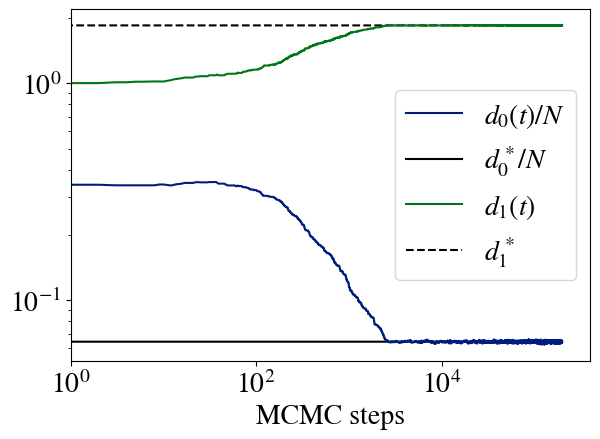

In [5]:
fig,ax = plt.subplots(1)
ax.plot(dynamics[:,0] / N,label=r'$d_0(t)/N$')
ax.plot([B.d0/N for i in range(N_iter)],color='black',label=r'$d_0^*/N$',zorder=0)
ax.plot(dynamics[:,1] ,label=r'$d_1(t)$')
ax.plot([B.d1 for i in range(N_iter)],color='black',linestyle='dashed',label=r'$d_1^*$',zorder=0)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1,2 * len(dynamics))
ax.legend(loc='center right')
ax.set_xlabel('MCMC steps')
plt.show()

In [6]:
def autocorrelation_function(dynamics,t_min,idx=0):
  m = dynamics[t_min : len(dynamics),idx]
  t_max = len(m) // 10
  t_list = range(0,t_max)
  chi = np.zeros(shape=(len(t_list),))
  for t_id,t in enumerate(t_list):
    chi[t_id] = np.sum(m[:t_max-t] * m[t:t_max]) / (t_max-t)
    chi[t_id] -= (1/(t_max-t)**2) * np.sum(m[:t_max-t]) * np.sum(m[t:t_max])
  return chi
t_min = int(1E4)
chi = autocorrelation_function(dynamics,t_min=t_min)

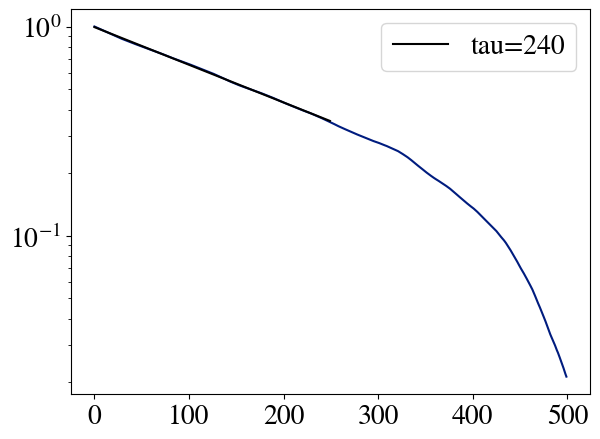

In [7]:
t_fit = 250
p, cov = np.polyfit(range(t_fit),np.log(chi[:t_fit]),deg=1,cov=True)
tau = int(-1 / p[0])

fig,ax = plt.subplots(1)
ax.plot(chi[:500] / chi[0])
k = 1
ax.plot(np.arange(k*t_fit),np.exp(p[0] * np.arange(k*t_fit) + p[1]) / chi[0],color='black',label=f'{tau=}')
ax.set_yscale('log')
ax.legend()
plt.show()

[]

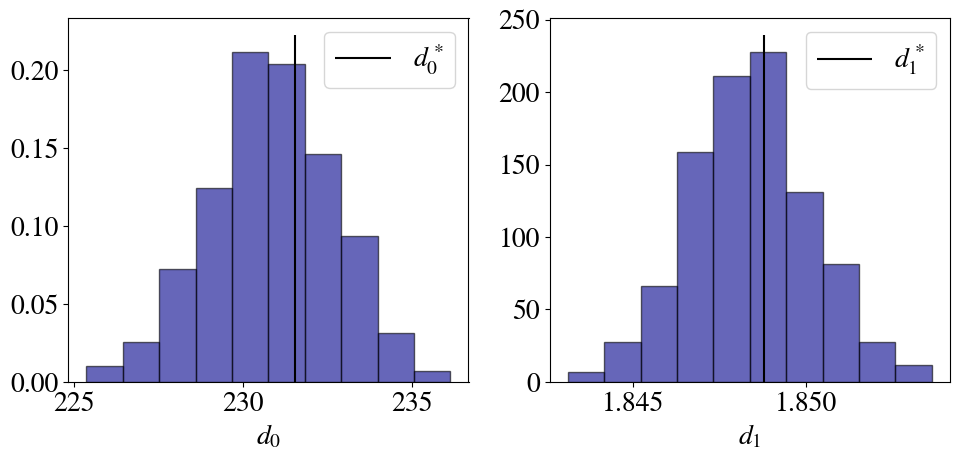

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for idx in [0,1]:
  samples = dynamics[t_min:,idx][::tau]
  counts,bin_edges = np.histogram(samples[:],density = True)
  ax[idx].bar(bin_edges[:-1], counts, width=np.diff(bin_edges), alpha=0.6, color='darkblue', edgecolor='black')
  if idx == 0:
    ax[idx].vlines(B.d0,ax[idx].get_ylim()[0],ax[idx].get_ylim()[1],color='black',label=r'$d_0^*$')
    ax[idx].set_xlabel(r'$d_0$')
  if idx == 1:
    ax[idx].vlines(B.d1,ax[idx].get_ylim()[0],ax[idx].get_ylim()[1],color='black',label=r'$d_1^*$')
    ax[idx].set_xlabel(r'$d_1$')
  ax[idx].legend()
plt.plot()

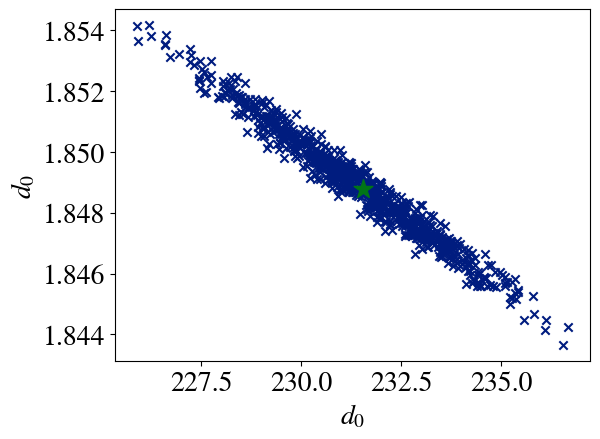

In [9]:
fig,ax = plt.subplots(1)

ax.scatter(dynamics[t_min:,0][::tau],dynamics[t_min:,1][::tau],marker='x')
ax.scatter(B.d0,B.d1,marker='*',s=200)
ax.set_xlabel(r'$d_0$')
ax.set_ylabel(r'$d_0$')

plt.show()

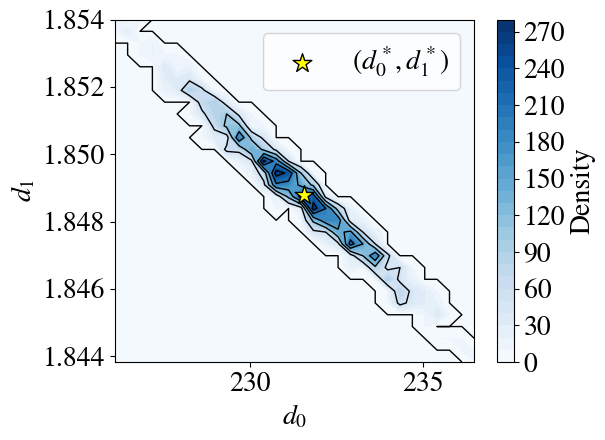

In [19]:
counts, x_edges, y_edges = np.histogram2d(dynamics[t_min:,0][::tau],dynamics[t_min:,1][::tau], bins=30, density=True)

# Compute bin centers
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

XX, YY = np.meshgrid(x_centers, y_centers)


fig,ax = plt.subplots(1)

# Plot contour map
levels = 5
ax.contourf(XX, YY, counts.T, levels=levels, cmap="Blues")  # Filled contours
fig.colorbar(ax.contourf(XX, YY, counts.T, levels=30, cmap="Blues"), ax=ax, label="Density")
ax.contour(XX, YY, counts.T, levels=levels, colors="black", linewidths=1)  # Contour lines

ax.scatter(B.d0,B.d1,marker='*',s=200,label=r'$(d_0^*,d_1^*)$',color='yellow',zorder=3, edgecolor='black')


ax.set_xlabel(r'$d_0$')
ax.set_ylabel(r'$d_1$')
ax.legend()

plt.show()